In [1]:
import torch
import os
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchvision.datasets import FGVCAircraft
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision.models import resnet50,ResNet50_Weights
from torchvision import transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
from collections import Counter

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
trans = {
   'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
   

    'test' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}
    

In [4]:
sc_te= FGVCAircraft(root=os.path.expanduser("~/.cache"), download=True,split='test',transform=trans['train'])
sc_tr= FGVCAircraft(root=os.path.expanduser("~/.cache"), download=True,split='train',transform=trans['test'])
train_loader = DataLoader(sc_tr,batch_size=128,shuffle=True)
test_loader = DataLoader(sc_te,batch_size=128,shuffle=True)
print("FGVCAircraft train dataset size：", len(sc_tr))
print("FGVCAircraft testing dataset size：", len(sc_te))

FGVCAircraft train dataset size： 3334
FGVCAircraft testing dataset size： 3333


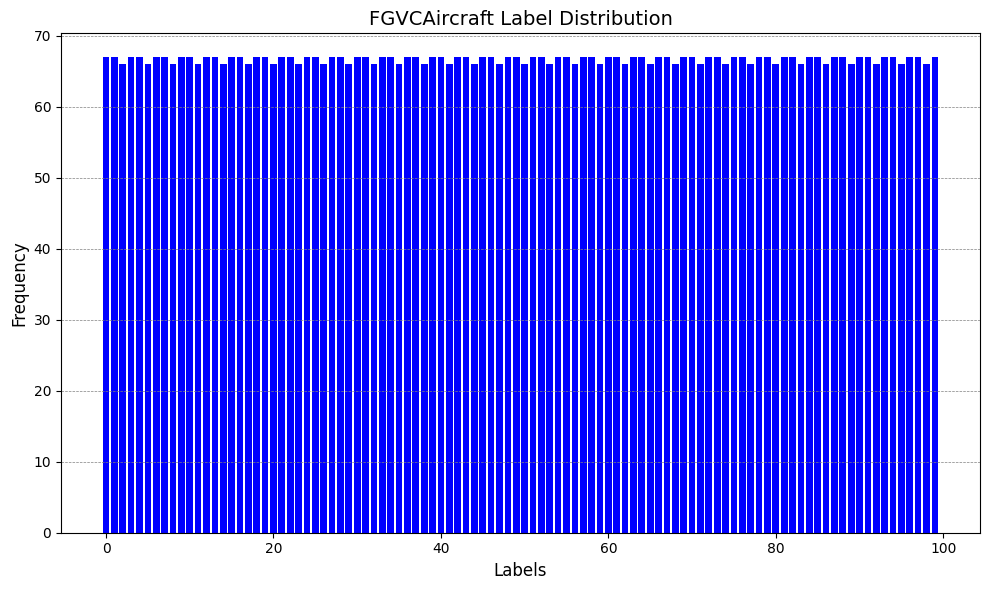

In [18]:
def plot_label_distribution(dataset):
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)

    values = list(label_counts.keys())
    counts = list(label_counts.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(values, counts, color='blue')

    ax.set_xlabel('Labels', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('FGVCAircraft Label Distribution', fontsize=14)
 
    ax.grid(color='gray', linestyle='--', linewidth=0.5, axis='y')
    plt.tight_layout()
    plt.show()

plot_label_distribution(FGVCAircraft(root=os.path.expanduser("~/.cache"), download=True))

In [5]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet.parameters():  
    param.requires_grad = False     

resnet.fc = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 100),
            nn.Softmax(dim = 1) 
            )

resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

criterion = nn.CrossEntropyLoss()
lr = 2e-3
optimizer = optim.Adam(resnet.fc.parameters(), lr = lr)
epochs = 20


for epoch in range(epochs): 
    
    resnet.train() 

    running_loss = 0.0
    num_samples = 0
    num_correct = 0
    for image, label in train_loader:
        image, label = image.to(device), label.to(device) 
        optimizer.zero_grad() 
        output = resnet(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)  
        num_samples += label.size(0)
        num_correct += (predicted == label).sum().item()
        
    train_accuracy = 100 * num_correct / num_samples
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        vr_loss = 0
        val_samples = 0
        val_corrects = 0
        for image, label in test_loader:
            image, label = image.to(device), label.to(device)
            output = resnet(image)
            _, predicted = torch.max(output, 1)
    
            
            val_samples += label.size(0)
            val_corrects += (predicted == label).sum().item()
            vr_loss += criterion(output, label).item()
        val_accuracy = 100 * val_corrects/val_samples
        val_loss = vr_loss/len(test_loader)
        print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {epoch_loss:.4f} - Training Accuracy: {train_accuracy:.2f}%")
        print(f"Epoch [{epoch + 1}/{epochs}] - Test Loss: {val_loss:.4f} - Test Accuracy: {val_accuracy:.2f}%")
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

Epoch [1/20] - Training Loss: 4.5994 - Training Accuracy: 4.41%
Epoch [1/20] - Test Loss: 4.5962 - Test Accuracy: 5.76%
Epoch [2/20] - Training Loss: 4.5512 - Training Accuracy: 16.68%
Epoch [2/20] - Test Loss: 4.5808 - Test Accuracy: 8.61%
Epoch [3/20] - Training Loss: 4.4656 - Training Accuracy: 31.43%
Epoch [3/20] - Test Loss: 4.5703 - Test Accuracy: 11.94%
Epoch [4/20] - Training Loss: 4.3561 - Training Accuracy: 45.08%
Epoch [4/20] - Test Loss: 4.5574 - Test Accuracy: 14.01%
Epoch [5/20] - Training Loss: 4.2658 - Training Accuracy: 54.56%
Epoch [5/20] - Test Loss: 4.5539 - Test Accuracy: 14.61%
Epoch [6/20] - Training Loss: 4.1876 - Training Accuracy: 60.53%
Epoch [6/20] - Test Loss: 4.5434 - Test Accuracy: 14.52%
Epoch [7/20] - Training Loss: 4.1287 - Training Accuracy: 65.87%
Epoch [7/20] - Test Loss: 4.5458 - Test Accuracy: 14.49%
Epoch [8/20] - Training Loss: 4.0636 - Training Accuracy: 69.86%
Epoch [8/20] - Test Loss: 4.5374 - Test Accuracy: 15.06%
Epoch [9/20] - Training Los

In [6]:
#torch.save(resnet.state_dict(), 'resnet3.pth')
resnet.load_state_dict(torch.load('resnet3.pth'))

<All keys matched successfully>

In [7]:
cal_dataloader = train_loader
test_dataloader = test_loader
model = resnet

model.eval()

# Options of score function: THR, APS, SAPS, RAPS
# Define a conformal prediction algorithm. Optional: SplitPredictor, ClusterPredictor, ClassWisePredictor
def tcpTHR(pre,thr):
    predictor = pre(score_function=thr(), model=model)
    predictor.calibrate(cal_dataloader, alpha=0.1)
    inputs, classes = next(iter(test_dataloader))
    test_instances = inputs
    predict_set = predictor.predict(test_instances)
    print(f"predict set:",predict_set)
    res_dict = predictor.evaluate(test_dataloader)
    print(" ")
    print(f"Coverage_rate:",res_dict["Coverage_rate"], "Average_size",res_dict["Average_size"])
    return predict_set,res_dict["Coverage_rate"],res_dict["Average_size"]

## SplitPredictor+THR

In [8]:
ST0,ST1,ST2=tcpTHR(SplitPredictor,THR)

predict set: [[0, 10, 11, 21, 23, 26, 34, 36, 38, 41, 42, 45, 47, 49, 50, 52, 58, 64, 66, 69, 75, 77, 80, 83, 89, 90, 92, 95, 96, 97], [33, 34, 36, 39, 40, 42, 44, 45, 48, 49, 50, 51, 59, 60, 63, 73, 78, 80, 90, 93, 94, 99], [7, 14, 16, 48, 49, 50, 59, 67, 69, 74, 75, 80, 81, 82, 90, 92, 94], [0, 3, 4, 6, 7, 8, 12, 13, 14, 18, 25, 26, 33, 34, 41, 43, 45, 46, 51, 55, 58, 60, 69, 70, 76, 77, 78, 83, 86, 88, 89, 94, 97, 98], [4, 8, 9, 11, 12, 13, 20, 21, 22, 23, 27, 28, 29, 30, 31, 32, 37, 38, 45, 46, 63, 64, 66, 67, 73, 82, 86, 87, 88], [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 21, 22, 24, 25, 26, 28, 30, 34, 38, 41, 46, 56, 69, 76, 78, 84, 86, 93, 97, 98], [3, 6, 7, 16, 18, 21, 22, 23, 24, 26, 34, 37, 38, 41, 42, 51, 54, 61, 63, 67, 68, 69, 77, 83, 85, 88, 92, 93], [5, 7, 10, 11, 12, 16, 17, 18, 20, 22, 23, 24, 33, 37, 38, 44, 45, 52, 59, 66, 84, 85], [16, 17, 34, 39, 43, 49, 50, 53, 57, 58, 60, 62, 71, 75, 77, 79, 81, 95, 96, 97, 99], [12, 15, 19, 20, 27, 29, 31, 32, 33, 63, 76

## ClassWisePredictor+APS

In [9]:
m=model.cpu()
predictor = ClassWisePredictor(score_function=APS(), model=m)
predictor.calibrate(cal_dataloader, alpha=0.1)
inputs, classes = next(iter(test_dataloader))
test_instances = inputs.cpu()
SA0 = predictor.predict(test_instances)
print(f"predict set:",SA0)
res_dict = predictor.evaluate(test_dataloader)
print(" ")
SA1=res_dict["Coverage_rate"]
SA2=res_dict["Average_size"]
print(f"Coverage_rate:",SA1, "Average_size",SA2)

predict set: [[1, 10, 11, 12, 13, 25, 28, 29, 31, 32, 35, 43, 44, 45, 52, 61, 64, 65, 67, 82, 97, 99], [0, 1, 2, 3, 10, 11, 12, 13, 17, 22, 29, 30, 35, 52, 55, 56, 61, 84, 99], [0, 1, 2, 3, 10, 14, 25, 29, 30, 40, 41, 44, 45, 52, 54, 56, 68, 69, 70, 85, 86, 99], [11, 13, 20, 22, 23, 25, 31, 32, 41, 42, 44, 45, 51, 52, 76, 80, 85, 87, 97, 99], [8, 9, 13, 19, 20, 22, 27, 28, 29, 30, 31, 32, 35, 44, 45, 46, 52, 55, 56, 61, 65, 70, 76, 80, 85, 86, 87, 88, 99], [0, 1, 10, 11, 13, 17, 19, 21, 22, 26, 28, 29, 30, 35, 41, 45, 52, 54, 55, 56, 78, 84, 85, 86, 97, 99], [7, 11, 13, 16, 17, 20, 22, 23, 24, 27, 28, 34, 38, 43, 52, 61, 65, 68, 78, 79, 85, 87], [1, 4, 17, 20, 35, 44, 45, 46, 61, 65, 68, 69, 70, 78, 79, 80, 81, 86, 87, 99], [1, 2, 8, 12, 19, 22, 25, 28, 34, 35, 44, 45, 52, 55, 61, 67, 80, 87, 97, 99], [11, 12, 13, 19, 23, 29, 31, 35, 37, 40, 44, 45, 46, 61, 63, 64, 65, 66, 76, 79, 80, 87, 93, 99], [0, 1, 8, 13, 19, 20, 25, 26, 27, 28, 29, 30, 31, 32, 35, 44, 45, 46, 52, 54, 55, 61, 65,

## ClassWisePredictor+SAPS

In [10]:
predictor = ClassWisePredictor(score_function=SAPS(0.2), model=model)
predictor.calibrate(cal_dataloader, alpha=0.1)
inputs, classes = next(iter(test_dataloader))
test_instances = inputs
SS0 = predictor.predict(test_instances)
print(f"predict set:",SS0)
res_dict = predictor.evaluate(test_dataloader)
print(" ")
SS1=res_dict["Coverage_rate"]
SS2=res_dict["Average_size"]
print(f"Coverage_rate:",SS1, "Average_size",SS2)

predict set: [[4, 9, 13, 25, 29, 30, 31, 32, 34, 35, 36, 44, 45, 46, 54, 61, 65, 76, 78, 80, 87], [17, 22, 25, 27, 29, 30, 31, 33, 35, 37, 38, 39, 44, 45, 51, 52, 64, 80, 98, 99], [3, 4, 8, 9, 10, 11, 16, 19, 22, 23, 26, 27, 30, 31, 35, 44, 45, 52, 56, 61, 65, 69, 76, 78, 86, 87, 99], [0, 1, 3, 8, 10, 13, 22, 26, 27, 28, 30, 34, 35, 40, 41, 44, 45, 46, 52, 56, 61, 65, 78, 89, 93, 97, 99], [1, 3, 4, 13, 14, 16, 17, 22, 26, 27, 29, 35, 41, 45, 46, 55, 61, 65, 69, 78, 98, 99], [1, 8, 10, 13, 14, 20, 22, 24, 25, 27, 29, 30, 31, 32, 33, 35, 41, 44, 45, 52, 56, 61, 65, 76, 78, 84, 86, 87, 88, 98, 99], [0, 1, 10, 11, 17, 19, 22, 23, 27, 43, 45, 52, 55, 79, 80, 85], [1, 2, 3, 8, 9, 10, 13, 14, 19, 25, 26, 27, 28, 29, 30, 35, 41, 44, 46, 52, 55, 65, 68, 70, 76, 78, 85, 86, 87, 88, 98], [2, 8, 10, 19, 34, 35, 36, 44, 45, 46, 61, 65, 70, 73, 76, 78, 79, 86, 87, 99], [1, 22, 31, 34, 36, 43, 44, 45, 50, 52, 56, 61, 69, 80, 87, 99], [9, 12, 13, 17, 22, 27, 28, 29, 30, 31, 32, 35, 44, 45, 46, 52, 61,

## ClassWisePredictor+RAPS

In [11]:
predictor = ClassWisePredictor(score_function=RAPS(1,0), model=model)
predictor.calibrate(cal_dataloader, alpha=0.1)
inputs, classes = next(iter(test_dataloader))
test_instances = inputs
SR0 = predictor.predict(test_instances)
print(f"predict set:",SR0)
res_dict = predictor.evaluate(test_dataloader)
print(" ")
SR1=res_dict["Coverage_rate"]
SR2=res_dict["Average_size"]
print(f"Coverage_rate:",SR1, "Average_size",SR2)

predict set: [[0, 1, 7, 10, 13, 17, 21, 22, 24, 25, 28, 29, 30, 40, 41, 44, 45, 52, 55, 60, 61, 98, 99], [0, 1, 2, 10, 11, 12, 13, 17, 20, 27, 28, 29, 30, 32, 35, 45, 46, 52, 55, 61, 65, 76, 78, 86, 87, 88, 99], [1, 16, 17, 23, 27, 30, 35, 36, 40, 44, 55, 61, 62, 80], [0, 1, 2, 4, 9, 10, 22, 23, 25, 26, 27, 29, 30, 31, 33, 40, 44, 45, 51, 52, 61, 64, 65, 68, 80, 85, 86, 99], [7, 8, 9, 10, 14, 19, 22, 26, 27, 35, 40, 44, 46, 52, 55, 61, 65, 69, 76, 78, 80, 85, 86, 87, 89, 98, 99], [0, 1, 2, 3, 4, 10, 14, 17, 25, 26, 29, 30, 32, 35, 41, 44, 45, 52, 55, 56, 69, 76, 80, 85, 97, 98, 99], [0, 1, 2, 11, 13, 17, 19, 20, 21, 22, 25, 29, 35, 44, 45, 52, 55, 56, 76, 80, 81, 84, 87, 99], [3, 5, 6, 7, 10, 11, 17, 22, 23, 24, 25, 26, 27, 28, 29, 30, 52, 65, 66, 84, 85, 99], [1, 12, 13, 19, 20, 25, 28, 29, 30, 32, 35, 36, 41, 45, 46, 52, 61, 69, 70, 76, 80, 86, 87, 88, 89, 93, 99], [0, 1, 2, 3, 9, 10, 14, 16, 17, 22, 23, 25, 27, 28, 40, 41, 44, 45, 52, 55, 56, 61, 65, 78, 79, 80, 81, 89, 97, 99], [7,

## ClusterPredictor+THR

In [12]:
CLU0,CLUT1,CLUT2=tcpTHR(ClusterPredictor,THR)

predict set: [[0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 17, 19, 22, 25, 27, 33, 42, 43, 44, 45, 46, 51, 52, 56, 61, 65, 67, 70, 73, 76, 80, 81, 83, 85, 86, 88, 97, 98, 99], [0, 10, 11, 12, 13, 14, 18, 22, 27, 32, 35, 51, 52, 84, 85, 86, 88, 98], [4, 11, 14, 19, 25, 27, 34, 35, 37, 38, 43, 44, 51, 56, 70, 81, 87, 99], [0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 14, 16, 17, 19, 21, 22, 25, 27, 33, 35, 44, 45, 51, 52, 55, 56, 65, 70, 81, 84, 85, 87, 88, 97, 99], [0, 4, 7, 11, 13, 16, 17, 22, 23, 25, 26, 33, 45, 64, 97, 99], [10, 11, 22, 43, 53, 54, 55, 85], [11, 12, 13, 14, 17, 19, 20, 22, 25, 32, 33, 38, 44, 51, 52, 66, 70, 76, 81, 84, 85], [0, 2, 4, 7, 8, 10, 11, 12, 13, 14, 17, 19, 20, 22, 25, 27, 28, 29, 30, 31, 32, 33, 35, 44, 45, 51, 52, 56, 61, 65, 70, 76, 81, 86, 87, 88, 89, 99], [10, 11, 12, 13, 17, 20, 22, 25, 33, 38, 43, 44, 51, 52, 56, 59, 60, 70, 73, 81, 83, 84, 99], [0, 3, 4, 8, 10, 11, 12, 13, 14, 19, 20, 22, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 44, 45, 46, 51, 52, 56, 61, 70, 76, 81, 8

## ClassWisePredictor+THR

In [13]:
CT0,CT1,CT2=tcpTHR(ClassWisePredictor,THR)

predict set: [[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22, 25, 26, 27, 28, 29, 30, 31, 33, 35, 38, 41, 44, 45, 46, 52, 54, 55, 61, 64, 65, 76, 81, 85, 87, 88, 97], [1, 3, 10, 11, 12, 13, 19, 22, 25, 28, 29, 31, 41, 44, 45, 46, 52, 55, 56, 76, 80, 86, 87, 88, 89], [3, 4, 8, 10, 11, 12, 13, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 35, 36, 44, 45, 46, 51, 52, 54, 55, 61, 65, 76, 78, 80, 84, 85, 86, 87, 89, 94, 99], [1, 4, 17, 19, 25, 28, 35, 44, 45, 46, 52, 55, 64, 65, 66, 69, 80, 81, 87], [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 16, 17, 19, 22, 25, 27, 28, 29, 30, 31, 33, 35, 44, 45, 46, 51, 52, 56, 61, 65, 76, 84, 85, 86, 87, 97, 99], [0, 1, 2, 3, 8, 10, 11, 13, 17, 19, 22, 25, 27, 28, 29, 30, 31, 35, 37, 44, 45, 46, 51, 52, 54, 56, 61, 63, 65, 69, 70, 76, 79, 80, 86, 87, 88, 98, 99], [0, 2, 3, 4, 8, 9, 10, 11, 12, 13, 17, 19, 20, 22, 25, 27, 28, 29, 30, 31, 32, 35, 44, 45, 46, 52, 54, 55, 61, 65, 66, 76, 78, 86, 87, 88, 98], [1, 3, 4, 6, 8, 10, 17, 19, 22, 25, 27, 28

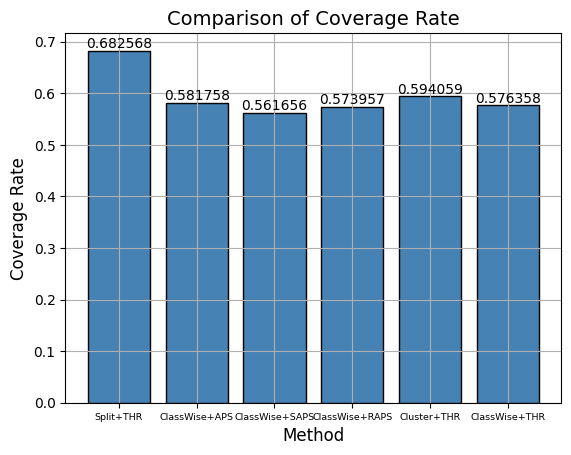

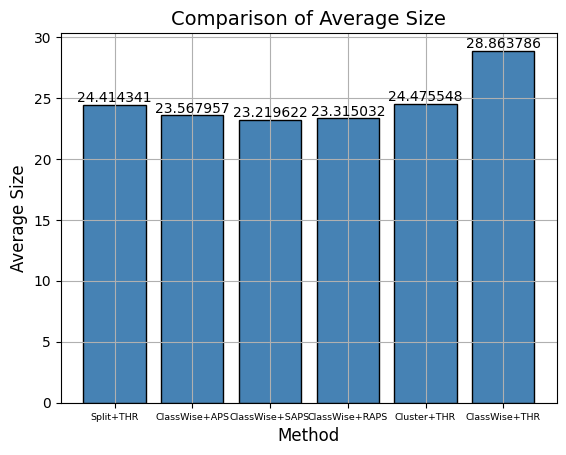

In [19]:
methods=["Split+THR","ClassWise+APS","ClassWise+SAPS","ClassWise+RAPS","Cluster+THR","ClassWise+THR"]
cr=[ST1,SA1,SS1,SR1,CLUT1,CT1]
avs=[ST2,SA2,SS2,SR2,CLUT2,CT2]
plt.bar(methods,cr, color='steelblue', edgecolor='black')
plt.xlabel("Method", fontsize=12)
plt.ylabel("Coverage Rate", fontsize=12)
plt.title("Comparison of Coverage Rate", fontsize=14)
for i, v in enumerate(cr):
    plt.text(i, v, str(round(v,6)), ha='center', va='bottom')
plt.xticks(fontsize=6.8)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

plt.bar(methods,avs, color='steelblue', edgecolor='black')
plt.xlabel("Method", fontsize=12)
plt.ylabel("Average Size", fontsize=12)
plt.title("Comparison of Average Size", fontsize=14)
for i, v in enumerate(avs):
    plt.text(i, v, str(round(v,6)), ha='center', va='bottom')
plt.xticks(fontsize=6.8)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

In [15]:
for i,v in zip(methods,[ST0[8],SA0[8],SS0[8],SR0[8],CLU0[8],CT0[8]]):
    print(i,"predictive interval for testset[8]:",v)
    print(" ")
data = {
    "Split+THR":ST0[8],
    "ClassWise+APS":SA0[8],
    "ClassWise+SAPS":SS0[8],
    "ClassWise+RAPS":SR0[8],
    "Cluster+THR":CLU0[8],
    "ClassWise+THR":CT0[8]
}

df = pd.DataFrame(columns=['Methods', 'Values'])

for method, values in data.items():
    df = df.append({'Methods': method, 'Values': values}, ignore_index=True)

df

Split+THR predictive interval for testset[8]: [16, 17, 34, 39, 43, 49, 50, 53, 57, 58, 60, 62, 71, 75, 77, 79, 81, 95, 96, 97, 99]
 
ClassWise+APS predictive interval for testset[8]: [1, 2, 8, 12, 19, 22, 25, 28, 34, 35, 44, 45, 52, 55, 61, 67, 80, 87, 97, 99]
 
ClassWise+SAPS predictive interval for testset[8]: [2, 8, 10, 19, 34, 35, 36, 44, 45, 46, 61, 65, 70, 73, 76, 78, 79, 86, 87, 99]
 
ClassWise+RAPS predictive interval for testset[8]: [1, 12, 13, 19, 20, 25, 28, 29, 30, 32, 35, 36, 41, 45, 46, 52, 61, 69, 70, 76, 80, 86, 87, 88, 89, 93, 99]
 
Cluster+THR predictive interval for testset[8]: [10, 11, 12, 13, 17, 20, 22, 25, 33, 38, 43, 44, 51, 52, 56, 59, 60, 70, 73, 81, 83, 84, 99]
 
ClassWise+THR predictive interval for testset[8]: [0, 1, 2, 3, 10, 11, 12, 17, 19, 22, 25, 27, 28, 29, 30, 31, 33, 35, 36, 41, 44, 45, 46, 51, 52, 54, 61, 65, 73, 76, 78, 80, 81, 86, 87, 88, 97, 98, 99]
 


/tmp/ipykernel_6835/898339814.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Methods': method, 'Values': values}, ignore_index=True)
/tmp/ipykernel_6835/898339814.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Methods': method, 'Values': values}, ignore_index=True)
/tmp/ipykernel_6835/898339814.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Methods': method, 'Values': values}, ignore_index=True)
/tmp/ipykernel_6835/898339814.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Methods': method, 'Values': values}, ignore_index=True)
/tmp/ipykernel_6835/

,Methods,Values
0,Split+THR,"[16, 17, 34, 39, 43, 49, 50, 53, 57, 58, 60, 6..."
1,ClassWise+APS,"[1, 2, 8, 12, 19, 22, 25, 28, 34, 35, 44, 45, ..."
2,ClassWise+SAPS,"[2, 8, 10, 19, 34, 35, 36, 44, 45, 46, 61, 65,..."
3,ClassWise+RAPS,"[1, 12, 13, 19, 20, 25, 28, 29, 30, 32, 35, 36..."
4,Cluster+THR,"[10, 11, 12, 13, 17, 20, 22, 25, 33, 38, 43, 4..."
5,ClassWise+THR,"[0, 1, 2, 3, 10, 11, 12, 17, 19, 22, 25, 27, 2..."
